### _Imports_

In [1]:
import pandas as pd
import numpy as np

import joblib

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.linear_model  import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pylab as plt

import functions as fn # importing pre-defined functions from .py file (inside notebooks folder)

### Upload diamonds train data from csv

In [2]:
diamonds_train = pd.read_csv('../data/diamonds_train.csv')
diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1


**Remark**: For the diamonds dataset, we have conducted an exploratory data analysis (EDA) in advance. Find references [here](https://github.com/Kristinawk/EDA_Diamonds).  
  
This dataset doesn't have nulls, therefore we can proceed directly with encoding.

## 1. Features selection and engineering

### Outliers

During EDA we saw that some diamonds have ceros in size parameters x, y and z. It would be better to take these rows out for machine learning.

In [3]:
len(diamonds_train.query('x == 0 or y == 0 or z == 0'))

16

In total, there are 16 rows with this issue. Lets drop these values.

In [4]:
diamonds_train.drop(diamonds_train.query('x == 0 or y == 0 or z == 0').index, inplace=True)

Now lets see the outliers in scatter plot

In [5]:
cat_var_lst = ["city", "cut", "color", "clarity"]
num_var_lst = ([i for i in list(diamonds_train.columns) if i not in cat_var_lst])

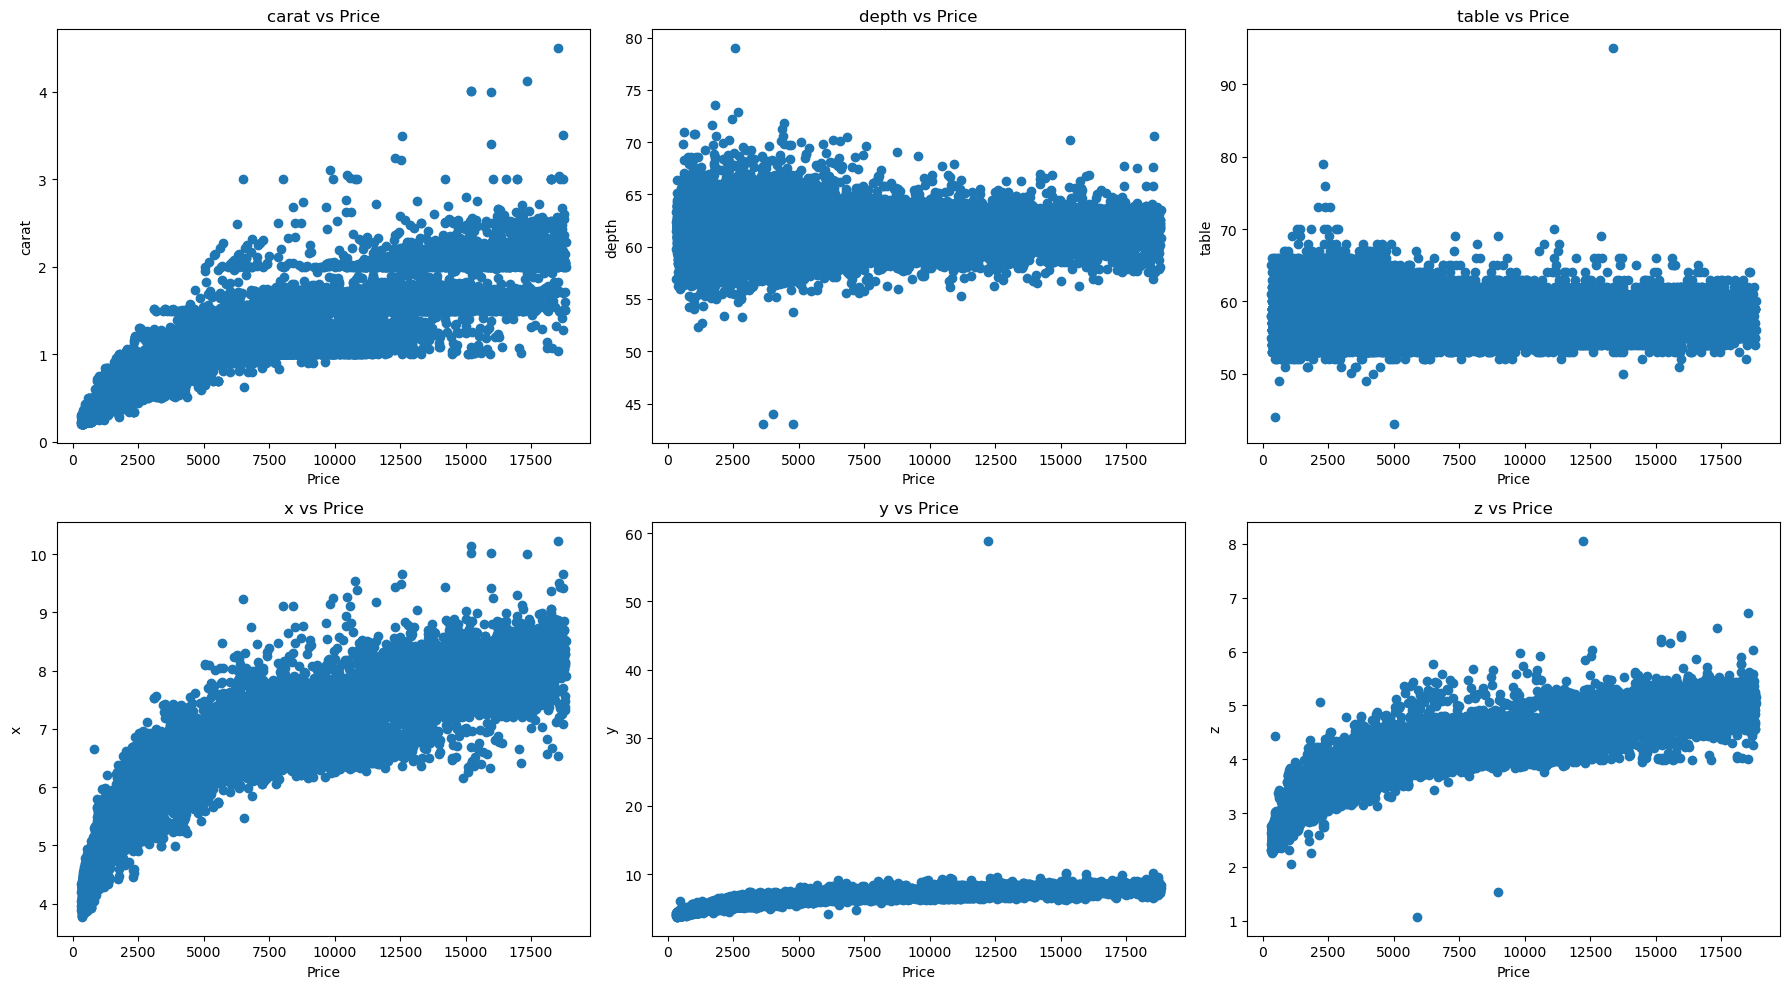

In [6]:
# Create a 2x3 grid of subplots (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Increase figsize for better spacing

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through the features and plot on the corresponding subplot
for i, feature in enumerate(num_var_lst[1:]):  # Adjust the range to match your desired features
    ax = axes[i]  # Access the subplot
    ax.scatter(diamonds_train['price'], diamonds_train[feature])  # Scatter plot on the current axis
    ax.set_xlabel('Price')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs Price')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Lets clean the dataset

In [7]:
len(diamonds_train.query('x > 30 or y > 30 or z > 30 or z < 2 or table > 80 or table < 40 or depth > 75 or depth < 45'))

8

In [8]:
diamonds_train.drop(diamonds_train.query('x > 30 or y > 30 or z > 30 or z < 2 or table > 80 or table < 40 or depth > 75 or depth < 45').index, inplace=True)

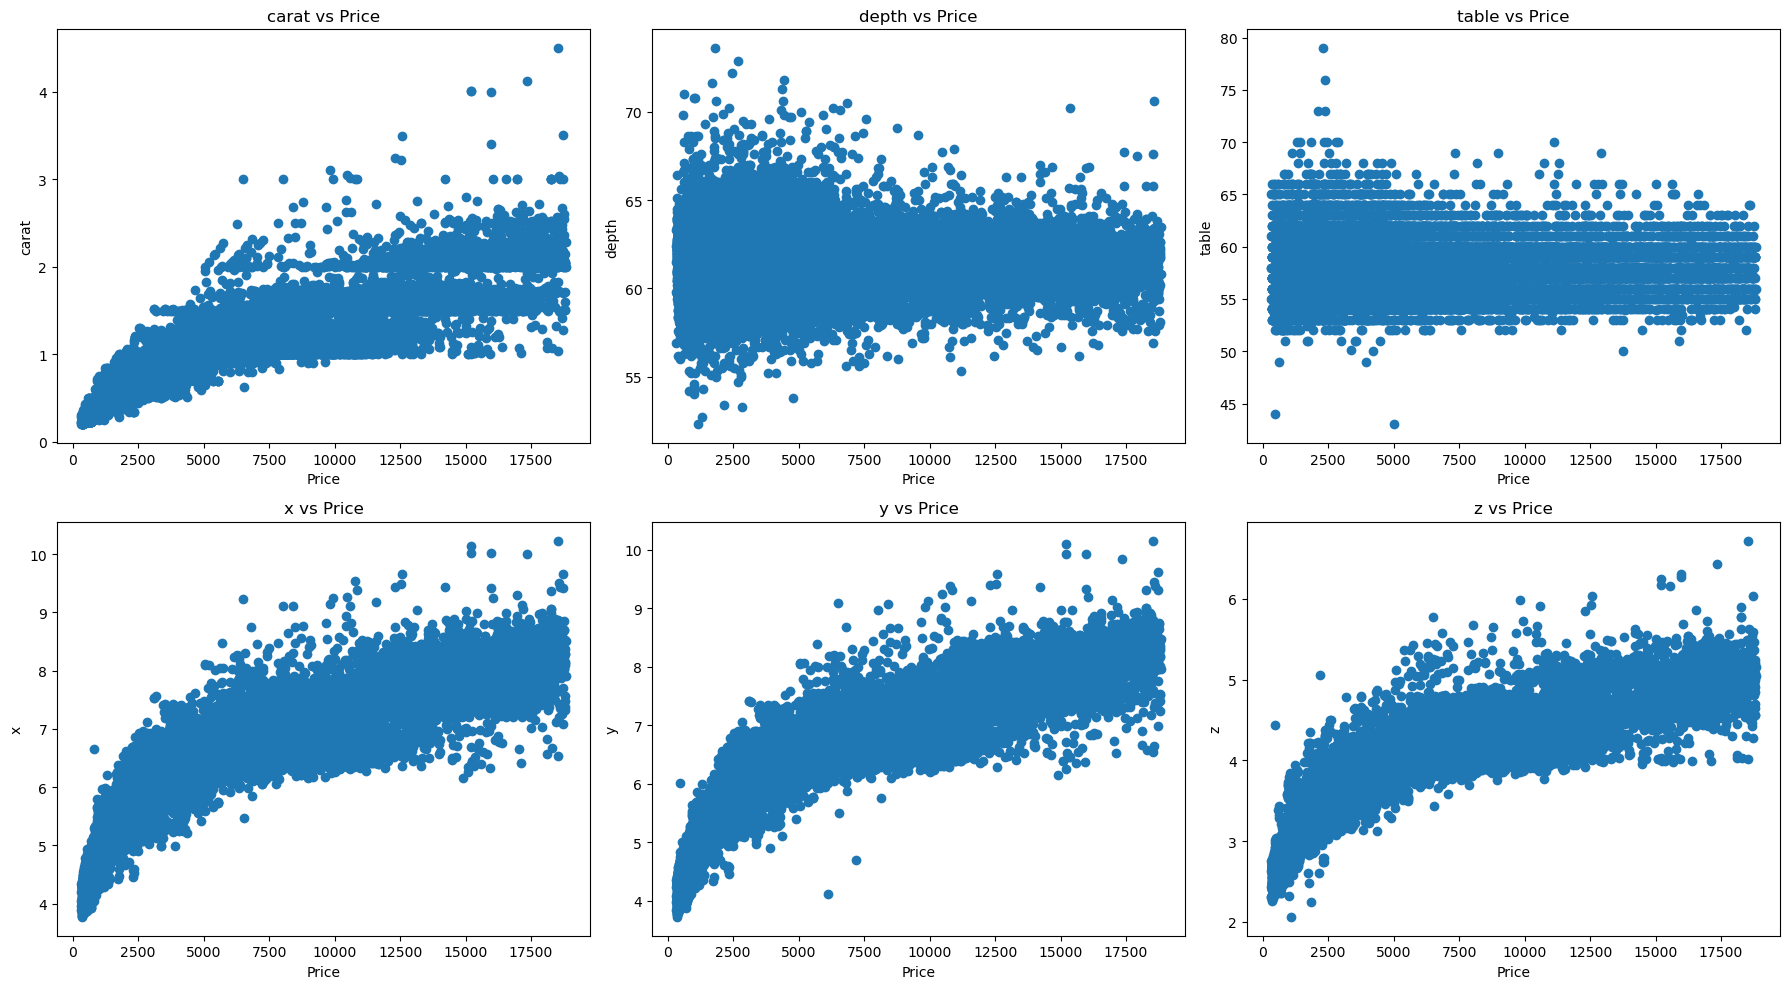

In [9]:
# Create a 2x3 grid of subplots (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Increase figsize for better spacing

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through the features and plot on the corresponding subplot
for i, feature in enumerate(num_var_lst[1:]):  # Adjust the range to match your desired features
    ax = axes[i]  # Access the subplot
    ax.scatter(diamonds_train['price'], diamonds_train[feature])  # Scatter plot on the current axis
    ax.set_xlabel('Price')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs Price')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

The dataset seems cleaner now

## 2. Encoding

### Categorical variables overview

In [10]:
cat_var_lst = ["city", "cut", "color", "clarity"]
cat_var_overview = fn.cat_var(diamonds_train, cat_var_lst)
cat_var_overview

,categorical_variable,number_of_possible_values,values
0,city,13,"[Dubai, Kimberly, Las Vegas, Tel Aviv, Amsterd..."
1,clarity,8,"[VS2, VS1, SI1, SI2, IF, VVS1, VVS2, I1]"
2,color,7,"[J, H, G, D, F, E, I]"
3,cut,5,"[Premium, Very Good, Fair, Good, Ideal]"


### One hot encoding

In [11]:
# city:

#baseline_train = fn.one_hot_encod(diamonds_train, 'city')

baseline_train = diamonds_train.drop("city", axis=1)
baseline_train.head()

,price,carat,depth,table,x,y,z,cut,color,clarity
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2
1,505,0.32,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1
3,738,0.41,63.8,56.0,4.68,4.72,3.00,Good,D,SI1
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1


### Label encoding

In [12]:
# Apply label encoder to the rest of categorical variables:

def ordinal_encoding(x):
    for key in encoding:
        if x == key:
            return encoding[key]

,price,carat,depth,table,x,y,z,cut,color,clarity
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,3,6,5
1,505,0.32,63.0,57.0,4.35,4.38,2.75,4,4,5
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,0,3,4
3,738,0.41,63.8,56.0,4.68,4.72,3.00,1,0,2
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,2,3,2


In [13]:
encoding = {'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4, 'Ideal':5,
            'J':1, 'I':2, 'H':3, 'G':4, 'F':5, 'E':6, 'D':7,
            'I1':1, 'SI1':2, 'SI2':3, 'VS1':4, 'VS2':5, 'VVS1':6, 'VVS2':7, 'IF':8}()

array([6, 4, 3, 0, 2, 1, 5])

In [ ]:
baseline_train['cut'] = baseline_train['cut'].apply(ordinal_encoding)
baseline_train['color'] = baseline_train['color'].apply(ordinal_encoding)
baseline_train['clarity'] = baseline_train['clarity'].apply(ordinal_encoding)

## 3. Model selection

In [14]:
y = baseline_train['price']
X = baseline_train[[col for col in baseline_train.columns if col != 'price']]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
#print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

## 3. Stacking Regressor

In [16]:
# Define base models
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror")),
    ('lr', ExtraTreesRegressor(n_estimators=100, random_state=42))
]

# Define meta-model (Ridge regression)
meta_model = Ridge()

#    ('gb', GradientBoostingRegressor(n_estimators=100)),

stacking_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_model)

In [ ]:
fn.cross_val(stacking_regressor, X, y)

### Fit Model

In [17]:
stacking_regressort.fit(X_train, y_train)
y_pred = stacking_regressor.predict(X_test)

### Visual check

In [18]:
check = pd.DataFrame({'Ground truth': y_test, 'Predictions': y_pred, 'Diff': y_test - y_pred})
check

,Ground truth,Predictions,Diff
27976,2217,2149.15,67.85
39778,1798,1781.95,16.05
24999,13445,15969.51,-2524.51
13993,8044,8120.30,-76.30
39298,810,716.23,93.77
...,...,...,...
21151,1130,927.17,202.83
4642,6776,6499.83,276.17
32818,788,788.88,-0.88
34009,2283,2369.45,-86.45


In [19]:
check.reset_index(inplace=True)

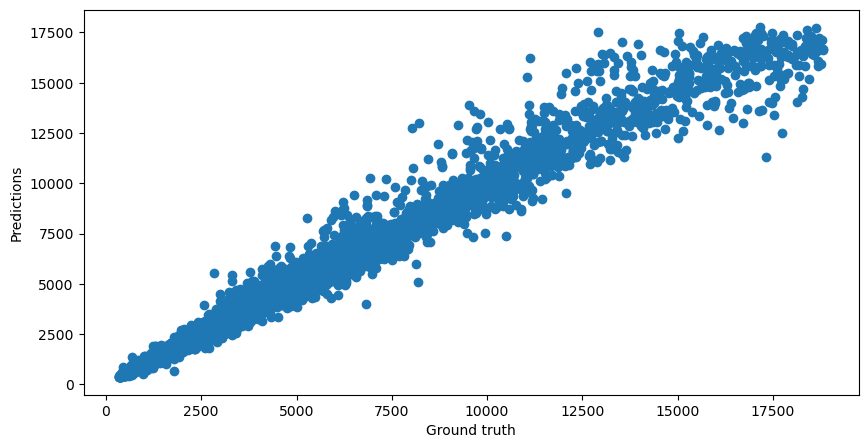

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax.scatter(y_test, y_pred)
ax.set_xlabel('Ground truth')
ax.set_ylabel('Predictions')
#ax.set_title('')
plt.show()

In [21]:
# Save the trained model
#joblib.dump(model_randomforest, 'test.pkl')

# 4. Predictions

### Upload diamonds test data from csv

In [22]:
diamonds_test = pd.read_csv('../data/diamonds_test.csv')
diamonds_test.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,city
0,0,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,Amsterdam
1,1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,Surat
2,2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,Kimberly
3,3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,Kimberly
4,4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,Amsterdam


### Encoding

In [23]:
baseline_test = diamonds_test[['carat', 'depth', 'table', 'x','y', 'z', 'cut', 'color', 'clarity']]

baseline_test.head()

,carat,depth,table,x,y,z,cut,color,clarity
0,0.79,62.7,60.0,5.82,5.89,3.67,Very Good,F,SI1
1,1.20,61.0,57.0,6.81,6.89,4.18,Ideal,J,VS1
2,1.57,62.2,61.0,7.38,7.32,4.57,Premium,H,SI1
3,0.90,63.8,54.0,6.09,6.13,3.90,Very Good,F,SI1
4,0.50,62.9,58.0,5.05,5.09,3.19,Very Good,F,VS1


In [24]:
label_encoder = LabelEncoder()
for col in ["cut", "color", "clarity"]:
    baseline_test[col] = label_encoder.fit_transform(baseline_test[col])
baseline_test.head()

C:\Users\Kristina\AppData\Local\Temp\ipykernel_17740\858337423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_test[col] = label_encoder.fit_transform(baseline_test[col])
C:\Users\Kristina\AppData\Local\Temp\ipykernel_17740\858337423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_test[col] = label_encoder.fit_transform(baseline_test[col])
C:\Users\Kristina\AppData\Local\Temp\ipykernel_17740\858337423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,carat,depth,table,x,y,z,cut,color,clarity
0,0.79,62.7,60.0,5.82,5.89,3.67,4,2,2
1,1.20,61.0,57.0,6.81,6.89,4.18,2,6,4
2,1.57,62.2,61.0,7.38,7.32,4.57,3,4,2
3,0.90,63.8,54.0,6.09,6.13,3.90,4,2,2
4,0.50,62.9,58.0,5.05,5.09,3.19,4,2,4


### Predict: StackingRegressor

In [25]:
#model_randomforest = joblib.load('test.pkl')

In [26]:
stacking_regressor_pred = stacking_regressor.predict(baseline_test)

In [27]:
stacking_regressor_pred

array([3009.65, 5323.5 , 9200.89, ..., 3012.35, 2225.34,  827.24],
      shape=(13485,))

### Save

In [28]:
fn.save_pred(diamonds_test, stacking_regressor_pred, 'encod03_featu00_model01_test3')

'file saved succesfully'